In [188]:
from datetime import datetime
import pandas as pd
import numpy as np
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
from vzorci_in_pomozne_definicije import *

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [12]:
podatkovna_baza = pd.read_json(FILENAME_POPOLNI_PODATKI_KARTE_JSON)

# Obravnava redkosti in cene

Kot prvo me je zanimalo, kakšna je povezava med redkostjo in ceno kart

<AxesSubplot: >

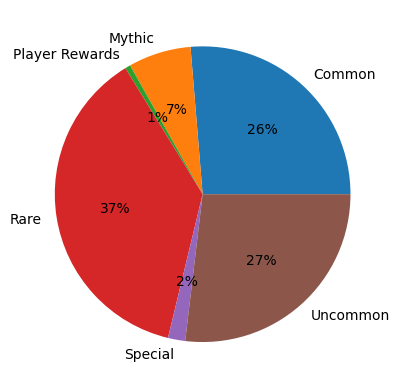

In [104]:
delezi_redkosti = podatkovna_baza.groupby("redkost").size()
delezi_redkosti.plot(kind="pie", autopct='%1.0f%%')

Text(0, 0.5, 'cena (v centih)')

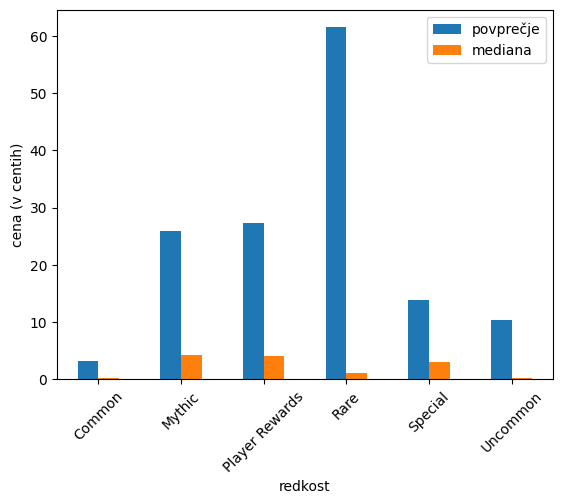

In [120]:
povprecna_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].mean()
mediana_cena_glede_na_redkost = podatkovna_baza.groupby("redkost")["povprecna_cena"].median()   

df = pd.DataFrame({'povprečje': povprecna_cena_glede_na_redkost,
                   'mediana': mediana_cena_glede_na_redkost}, index=None)

ax = df.plot.bar(rot=45)
ax.set_ylabel("cena (v centih)")


<AxesSubplot: title={'center': 'Razpored kart v cenovne razrede glede na evropske cene (€)'}>

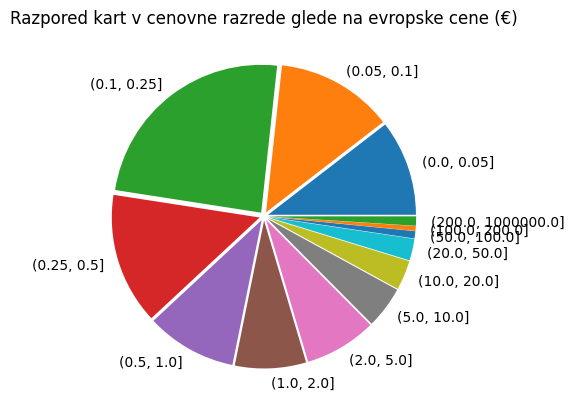

In [139]:
cenovni_razredi_kart = np.array([0, 0.05, 0.10, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 1000000])
explode = tuple([0.03 for _ in range(np.size(cenovni_razredi_kart) - 1)])
podatki_po_ceni_eu = podatkovna_baza.groupby(pd.cut(podatkovna_baza["povprecje_eu"], cenovni_razredi_kart)).size()

#pd.merge(podatki_po_ceni_eu, podatki_po_ceni_us).plot(kind = "bar")
podatki_po_ceni_eu.plot(kind = "pie", explode = explode, title='Razpored kart v cenovne razrede glede na evropske cene (€)')


# Tukaj je treba porihtati, da dobimo primerjavo ameriških cenovnih razredov z evropskimi

Pri ameriških cenah sem prva dva razreda zanemaril, saj sta bila skoraj popolnoma prazna.

<AxesSubplot: title={'center': 'Razpored kart v cenovne razrede glede na ameriške cene ($)'}>

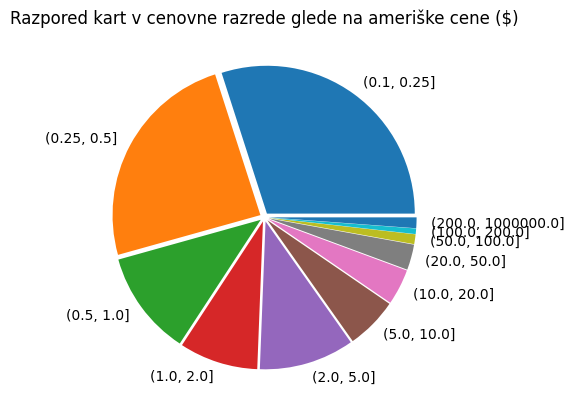

In [140]:
podatki_po_ceni_us = podatkovna_baza.groupby(pd.cut(podatkovna_baza["povprecna_cena"], cenovni_razredi_kart[2:])).size()
podatki_po_ceni_us.plot(kind = "pie", explode = explode[2:], title='Razpored kart v cenovne razrede glede na ameriške cene ($)')

# Analiza različnih tipov kart

Poleg cene in redkosti so me zanimali tudi podatki o raznih tipih [(*type*)](https://mtg.fandom.com/wiki/Card_type) in podtipih [(*subtype*)](https://mtg.fandom.com/wiki/Subtype) kart.

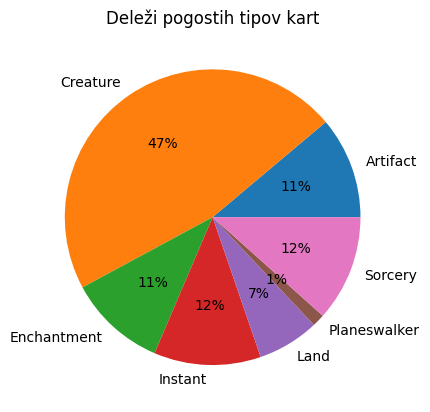

In [141]:
povezovalna_cardtype = pd.read_csv(os.path.join("Podatki", "Povezovalne_tabele", f"povezovalna_cardtype.csv"))
grupa_po_cardtypu = povezovalna_cardtype.groupby("cardtype")
velikost_grupe_po_cardtypu = grupa_po_cardtypu.size()
velikost_grupe_po_cardtypu[velikost_grupe_po_cardtypu > 100].plot.pie(title='Deleži pogostih tipov kart', autopct='%1.0f%%')
dovolj_veliki_kljuci_cardtypov = velikost_grupe_po_cardtypu[velikost_grupe_po_cardtypu > 100].keys()


<AxesSubplot: title={'center': 'Frekvenca najpogostejših creature tipov kart'}, xlabel='subtype'>

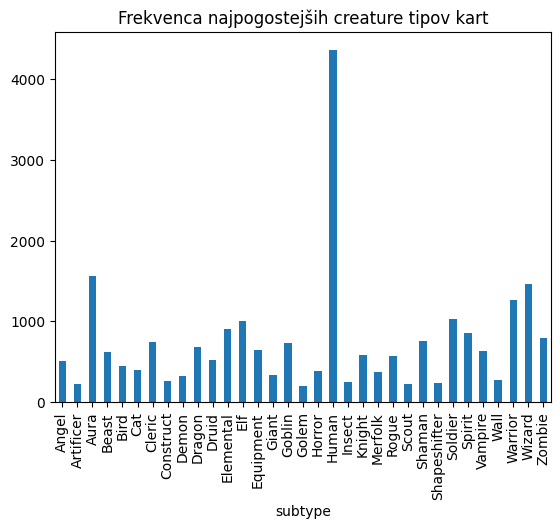

In [155]:
povezovalna_subtype = pd.read_csv(os.path.join("Podatki", "Povezovalne_tabele", "povezovalna_subtype.csv"))
grupa_po_subtypu = povezovalna_subtype.groupby("subtype")
velikost_grupe_po_subtypu = grupa_po_subtypu.size()
velikost_grupe_po_subtypu[velikost_grupe_po_subtypu > 200].plot.bar(title='Frekvenca najpogostejših creature tipov kart')
#povprecna_cena_glede_na_cardtype = podaytkovna_baza.groupby("cardtype")["povprecna_cena"].median()

Na spodnjem grafu razlika med različnimi vrednostmi lepo prikaže, kako majhno število kart po ceni močno odstopa od povprečja.

Text(0, 0.5, 'ameriška cena ($)')

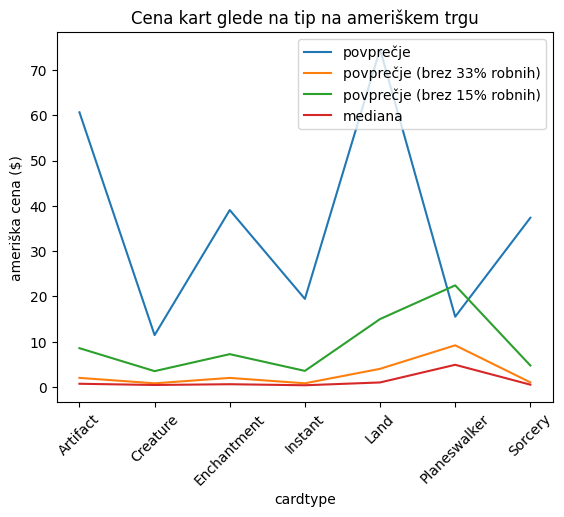

In [254]:
def q67(x):
    return x.quantile(0.67)

# 90th Percentile
def q85(x):
    return x.quantile(0.85)

tabela_povprecnih_cen = podatkovna_baza[["id_karte", "povprecna_cena"]].merge(povezovalna_cardtype)
povprecna_cena = tabela_povprecnih_cen.groupby("cardtype")["povprecna_cena"].mean()[dovolj_veliki_kljuci_cardtypov]
povprecna_cena_67 = tabela_povprecnih_cen.groupby("cardtype").agg({'povprecna_cena': q67}).loc[dovolj_veliki_kljuci_cardtypov]["povprecna_cena"]
povprecna_cena_85 = tabela_povprecnih_cen.groupby("cardtype").agg({'povprecna_cena': q85}).loc[dovolj_veliki_kljuci_cardtypov]["povprecna_cena"]
mediana = tabela_povprecnih_cen.groupby("cardtype")["povprecna_cena"].median()[dovolj_veliki_kljuci_cardtypov]

df = pd.DataFrame({'povprečje': povprecna_cena,
                   'povprečje (brez 33% robnih)': povprecna_cena_67,
                   'povprečje (brez 15% robnih)': povprecna_cena_85,
                   'mediana': mediana}, index=dovolj_veliki_kljuci_cardtypov)

ax = df.plot(rot=45, title="Cena kart glede na tip na ameriškem trgu")
ax.set_ylabel("ameriška cena ($)")

Text(0, 0.5, 'evropska cena (€)')

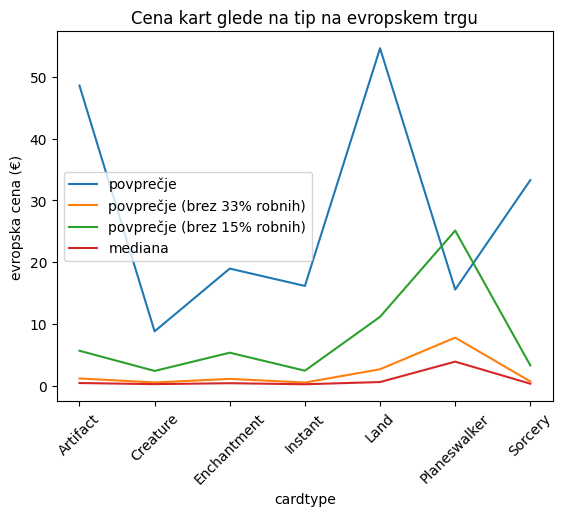

In [258]:
tabela_povprecnih_cen_eu = podatkovna_baza[["id_karte", "povprecje_eu"]].merge(povezovalna_cardtype)
povprecna_cena_eu = tabela_povprecnih_cen_eu.groupby("cardtype")["povprecje_eu"].mean()[dovolj_veliki_kljuci_cardtypov]
povprecna_cena_eu_67 = tabela_povprecnih_cen_eu.groupby("cardtype").agg({'povprecje_eu': q67}).loc[dovolj_veliki_kljuci_cardtypov]["povprecje_eu"]
povprecna_cena_eu_85 = tabela_povprecnih_cen_eu.groupby("cardtype").agg({'povprecje_eu': q85}).loc[dovolj_veliki_kljuci_cardtypov]["povprecje_eu"]
mediana = tabela_povprecnih_cen_eu.groupby("cardtype")["povprecje_eu"].median()[dovolj_veliki_kljuci_cardtypov]

df = pd.DataFrame({'povprečje': povprecna_cena_eu,
                   'povprečje (brez 33% robnih)': povprecna_cena_eu_67,
                   'povprečje (brez 15% robnih)': povprecna_cena_eu_85,
                   'mediana': mediana}, index=dovolj_veliki_kljuci_cardtypov)

ax = df.plot(rot=45, title="Cena kart glede na tip na evropskem trgu")
ax.set_ylabel("evropska cena (€)")